## Improving the Deep Learning model

In [14]:
# Charging the necessary dependencies
import numpy as np                              # Library for using arrays and numeric calculus
import matplotlib.pyplot as plt                 # Library for plotting 
#import seaborn as sns                           # Library for providing style to the charts
from sklearn import preprocessing               # Library for preprocessing data
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
#import shap
%matplotlib inline

In [15]:
# Charging the data in tensorflow version
npz = np.load('Data_train.npz')
train_inputs = npz['inputs'].astype(np.float)           # To ensure that they are all floats, let's also take care of that
train_targets = npz['targets'].astype(np.float)         # Targets are also float values

npz = np.load('Data_test.npz')
test_inputs = npz['inputs'].astype(np.float)
test_targets = npz['targets'].astype(np.float)

npz = np.load('Data_validation.npz')
valid_inputs = npz['inputs'].astype(np.float)
valid_targets = npz['targets'].astype(np.float)

## Defining a baseline model

In [16]:
# Defining hyperparamters
input_size = 4                  # Set the input and output sizes
output_size = 1
hidden_layer_size = 250
batch_size = 8
max_epochs = 450
early_stopping = EarlyStopping(patience=60)

# Defining the model architecture
model = Sequential([
    Dense(hidden_layer_size, activation = 'relu', kernel_initializer = 'he_uniform', input_shape = (input_size,)),
    Dense(hidden_layer_size, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(hidden_layer_size, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(hidden_layer_size, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(output_size)
])

# Defining an optimizer
my_optimizer = Adam(lr= 0.001) # , decay=1e-6
model.compile(optimizer = my_optimizer, loss='mse', metrics=['mae', 'mape'])

In [17]:
with open("model_summary_improved.txt", "w") as f:           # We open a file named "model_summary.txt" in written mode "w" and assigned it to the variable f
    model.summary(print_fn=lambda x: f.write(x +'\n')) # print_fn=lambda, write each line of the summary in the file utilizing the write method 
model.summary()                                     # Prints the model summary


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 250)               1250      
_________________________________________________________________
dense_6 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_7 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_8 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 251       
Total params: 189,751
Trainable params: 189,751
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit the model
checkpointer=ModelCheckpoint(filepath='model_weights_best.hdf5', verbose=0, save_best_only=True)

modelo = model.fit(train_inputs, train_targets, batch_size= batch_size,
                   epochs = max_epochs, callbacks=[checkpointer, early_stopping],
                   validation_data = (valid_inputs, valid_targets),
                   verbose= 0, shuffle=False)

In [19]:
loss = modelo.history['loss']
val_loss = modelo.history['val_loss']
epochs = range (len(loss))

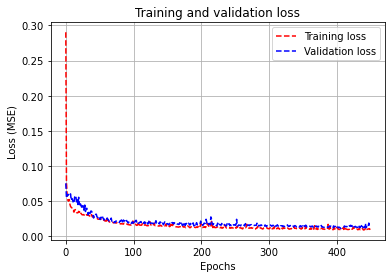

In [20]:
plt.plot(epochs, loss, 'r--', label = 'Training loss')
plt.plot(epochs, val_loss, 'b--', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.savefig("loss_improved.pdf")

In [21]:
# Obtaing the evaluation metrics for the validation instance
valid_loss = model.evaluate(valid_inputs, valid_targets)
valid_loss

10/10 [==============================] - 0s 1ms/step - loss: 0.0127 - mae: 0.0711 - mape: 24.3492


[0.012670077383518219, 0.07113667577505112, 24.34920310974121]

### Checking testing instance

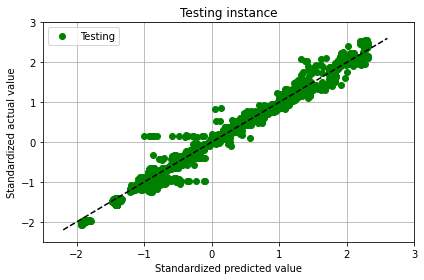

In [22]:
a = model.predict(test_inputs)
plt.plot(a, test_targets, 'go', label = 'Testing')
plt.title('Testing instance')
plt.xlabel('Standardized predicted value')
plt.ylabel('Standardized actual value')
plt.legend()
plt.axis([-2.5, 3, -2.5, 3])
x = np.linspace(-2.2, 2.6)
y = x
plt.plot(x, y, 'k--')
# fig = plt.figure.use('seaborn-v0_8', 'paper.mplstyle')
plt.grid()
plt.tight_layout()
plt.savefig("Testing_improved.pdf")

In [23]:
# Testing the model
test_loss = model.evaluate(test_inputs, test_targets)
test_loss

87/87 [==============================] - 0s 1ms/step - loss: 0.0161 - mae: 0.0764 - mape: 23.5521


[0.01611098274588585, 0.07644154131412506, 23.552122116088867]

In [24]:
# Computing the R2 score
r2_score(a, test_targets)
# 0.9825729536110313

0.9828980373745861

## Implementing gridsearch framework in the model to make an extreme fine-tuning process.
#### Until this point, we manually test different setups. However, no significant improvements were achieved. Now, we will check if we got the minimum value for the loss function.

In [25]:
def buildModel(hidden_layer_size): #hidden_layer_size, optimizer, epochs, lr, batch_size
    # Defining the model architecture
    model = Sequential([
    Dense(hidden_layer_size, activation = 'relu', kernel_initializer = 'he_uniform', input_shape = (input_size,)),
    Dense(hidden_layer_size, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(hidden_layer_size, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(hidden_layer_size, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(output_size) 
    ])
    # Defining an optimizer
    my_optimizer = Adam(lr = 0.001) # , decay=1e-6
    model.compile(optimizer = my_optimizer, loss='mse', metrics=['mse'])
    return model

# These lines of code import two important modules that are used for implementing GridSearch in 
# a neural network using KerasClassifier.
from sklearn.model_selection import GridSearchCV            # implements a grid search algorithm to find the best hyperparameters for a given estimator
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [26]:
# Defining the hyperparameters that we want to test in Gridsearch
parameters = {#'batch_size': [4,8,16,32,64,128],
              #'epochs': [500, 600],
              #'optimizer': ['adam', 'rmsprop', 'sgd'],
              'hidden_layer_size': [50,100,150,200,250,300],
              #'lr': [0.01, 0.001, 0.0001, 0.000001],
              }
# Create keras regressor
regresor = KerasRegressor(build_fn = buildModel)


grid_search = GridSearchCV(estimator = regresor,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 3)
# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=60)

grid_search = grid_search.fit(train_inputs, train_targets, epochs=max_epochs, shuffle=False, verbose=0,
                              batch_size=batch_size, callbacks=[early_stopping] )

NameError: name 'KerasRegressor' is not defined

In [ ]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: " + str(best_parameters))

NameError: name 'grid_search' is not defined

In [ ]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'grid_search' is not defined

# Computing the SHAP explainations
explainer = shap.Explainer(model.predict, train_inputs)
shap_values = explainer(test_inputs)

### Visualizing the SHAP explanations

shap.plots.heatmap(shap_values)

bar = shap.plots.bar(shap_values)
shap.summary_plot(shap_values, train_inputs, plot_type="bar", show=False)
plt.savefig("bar.pdf")

sample_index = 0
shap.plots.bar(shap_values[sample_index])

shap.force_plot(shap_values[0,:], train_inputs[0,:],show=False)

shap.summary_plot(shap_values, show=False)

feature_index = 0
shap.plots.bar(shap_values[:, feature_index])

shap.summary_plot(shap_values, train_inputs, plot_type="layered_violin", show=False)

sample_indices = [1]
feature_indices = [0]
shap.plots.bar(shap_values[sample_indices][:, feature_indices])

sample_index = 0
shap.plots.force(shap_values[sample_index])

shap_values